I recently encountered a high number of false alarms on a condition-monitoring and data acquisition device, whose primary analytical approach was an interesting fusion of a clustering algorithm and a state-space model. The algorithms involved were proprietary and opaque, so the solution required creative thinking based on some black-box outputs from the device.
Very important note: the data used in this notebook is entirely simulated and significantly different from any real-world applications, and no proprietary algorithms are discussed, merely a proposed data exploration approach.

The relevant data from the device included:

* Signal X; Continuous; ranging from -10 to 10
* Signal Y; Continuous; ranging from -10 to 10
* Alarm State; Categorical; either 0 or 1 (based on estimated equipment degradation)

Following is a non-detailed summary of the device's analytic approach. The models were trained using several days’ worth of data (and the training data was not saved), during which signals X and Y were used to create multiple data clusters. As each new data point was received, it was evaluated to determine its distance from an existing cluster. If the distance was large and enough data points were nearby, a new cluster was created. (This process was handled automatically by the device). When the device ran in real-time, the nearest cluster in the X-Y plane was selected for each new data point, and a proprietary state-space model (created separately for each cluster) determined the alarm state.

So, to summarize some of the major difficulties when working with this dataset:

* I did not construct the clustering algorithm or state-space model and only had a vague idea of what was happening behind-the-scenes.
* The created clusters were unavailable.
* Clustering algorithm performance metrics (such as the Silhouette Coefficient) were unavailable.
* Large cluster distance did not necessarily cause alarms. Rather, the alarms were created by a completely separate state-space model.
* The training data was unavailable.
* True alarms were unavailable, preventing an approach using a confusion matrix or ROC curve.

Based on what I knew of the device's analytic approach, I formulated the hypothesis that the false alarms were caused by an insufficient number of clusters being created during model training. If this hypothesis is true, I might expect to see an obvious data cluster that contains nothing but alarms when I plot Signal X vs. Signal Y:

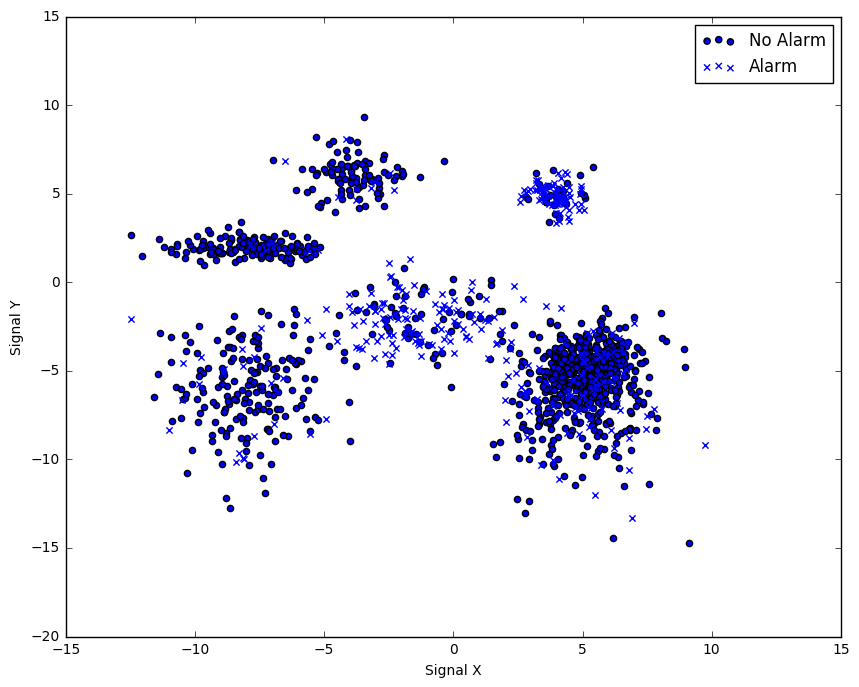

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
#The columns in the file are X-value, Y-value, Alarms, and
#Operational State (used later in the analysis) 
df = pd.read_csv('SampleClusterData.csv')
#I split the data into two parts: "good data" = no alarm
good_data = df.loc[df["Alarm"]==0]
bad_data = df.loc[df["Alarm"]==1]
#"Bad data" was marked with an "X", and "good data" with the
#default "O"
f = plt.figure(figsize=[10,8])
plt.scatter(good_data["X"],good_data["Y"])
plt.scatter(bad_data["X"],bad_data["Y"],marker="x")
plt.xlabel("Signal X")
plt.ylabel("Signal Y")
plt.legend(["No Alarm","Alarm"]);

However, as can be seen in the figure above, there were no obvious clusters containing only alarms (Xs). In fact, looking at this visual alone, the distribution of the alarms was seemingly unrelated to distance from a cluster! This outcome was not entirely unexpected, because as stated before, alarms were not directly triggered based on the distance to the nearest cluster.

The problem clearly deserved more exploration. My next idea was to cluster the available data using k-means. I hadn't forgotten that new clusters were only created during model training when **enough data points were nearby**. Since I didn't have access to the actual training data, it was entirely possible that even though my testing data contained what looked like six clusters, the training data might not have seen enough examples to create all six clusters. If certain clusters had higher percentages of alarms than others, that would be an important clue to indicate insufficient model training.

Alarm Percentages:
{0: 0.115, 1: 0.038, 2: 0.7, 3: 0.115, 4: 0.09, 5: 0.615}


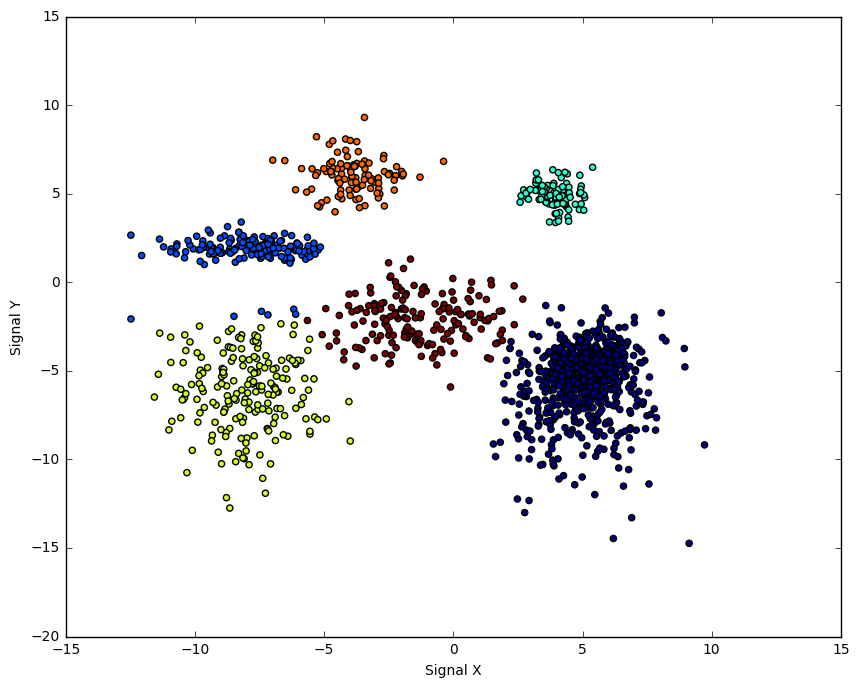

In [2]:
from sklearn.cluster import KMeans
import numpy as np

#Create a k-means clustering model. Since training data
#is not available, the model must be constructed with
#the available testing data (not usually good practice)
data = df[["X","Y"]]
kmeans = KMeans(n_clusters=6, random_state=0).fit(data)
df["Clust"] = kmeans.labels_
#Plot the results. Each of the "labels" above will be
#assigned a different color on the plot.
f = plt.figure(figsize=[10,8])
plt.scatter(df["X"],df["Y"],c=df["Clust"].astype(np.float));
plt.xlabel("Signal X")
plt.ylabel("Signal Y")
#Now that each data point has been assigned to a cluster,
#determine the percentage of alarms for each cluster.
#Converting kmeans.labels_ to a set means that we only
#get the unique labels (six), not the label for each point
labelset = set(kmeans.labels_)
perc_alarms = {}
for label in labelset:
    num_alarms = len(df.loc[(df["Clust"]==label) & (df["Alarm"]==1)])
    num_pts = len(df.loc[(df["Clust"]==label)])
    perc_alarms[label] = round(num_alarms/num_pts,3)
print("Alarm Percentages:")
print(perc_alarms)

Clusters 2 and 5 clearly have a much higher percentage of alarms than the other clusters. This result supported my hypothesis about insufficient model training: it seemed likely that these clusters were not actually created when the models were trained. Since large cluster distance does not directly cause an alarm, it also makes sense that the alarm percentages were not 100% for the untrained clusters.

However, this data exploration immediately lead to the question- can I find a way to determine if the models have been adequately trained for some unknown future case? If I believe model training is insufficient, I can automatically trigger the device to continue in training mode, but I never have access to any of the training data, so how could I possibly determine if model training is adequate or not?

The solution I found was to incorporate domain knowledge about the data. I had access to other sensors not collected by the device which I believed might affect calculation of an alarm. I assigned each data point a category from 1-9 based on combinations of possible signal boolean expressions (e.g. one such combination might be high Signal A, low Signal B, high Signal C). Rest assured, this categorization did make sense from a domain knowledge standpoint.

Following are the results that I found.

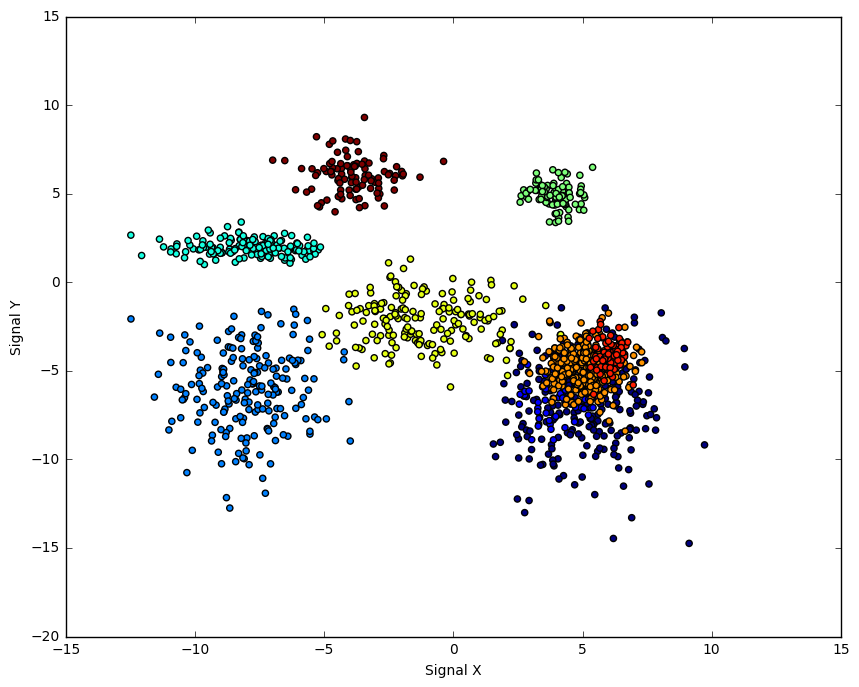

In [3]:
f = plt.figure(figsize=[10,8])
plt.scatter(df["X"],df["Y"],c=df["Op"].astype(np.float));
plt.xlabel("Signal X")
plt.ylabel("Signal Y");

Although the data in this example is of course simulated, I found a very similar result as in the figure above. Each cluster consisted almost entirely of boolean combinations of sensors I **did** have access to. Some clusters were populated by several boolean combinations (e.g. the cluster with red, orange, blue), but all clusters were fairly separable. In conclusion, an automatic solution was constructed such that the device continued its training period until it had spent sufficient time in each boolean combination.